# Regression Coding Challenge 2: Pre-processing the Raw Titanic Dataset

Within yesterday's challenge, we began our journey towards creating a regression model capable of predicting the survivors of the historic sinking of the Titanic. 

For today's challenge, we expand upon this exploration by cleaning our data and performing feature engineering; ensuring that it is ready for use in various modelling strategies.  

<br></br>

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://i.kinja-img.com/gawker-media/image/upload/fhygjbyvm8rorm1uyg6s.jpg"
     alt="Barnicles on your ship :( "
     style="float: center; padding-bottom=0.5em"
     width=600px/>
Time to clean some ship data!
</div>


## Pre-requisites 

Before getting your hands dirty in this challenge (or erm... cleaning them), please ensure that the following steps have been taken:

 1. You have completed _Regression Coding Challenge 1_. The coding challenges are designed to build upon one another, mimicking a process you will follow for most of your data science projects. 
 
 2. You have reviewed and are comfortable with the Titanic dataset contents. A further description of each field within the dataset can be found [here](https://www.kaggle.com/c/titanic/data)
 
With these steps out of the way, we're ready to begin!

### Imports 

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data Review

In [0]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/titanic_train_raw.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/titanic_test_raw.csv')

In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Question 1: Handling Missing Data

Having a comprehensive view of our dataset afforded by its exploration, we are ready to begin the first step of cleaning our data by considering cases of missing values.

### Question 1.1: Removing Features

In Question 1 of Challenge 1, we learnt that certain columns within our dataset had a high percentage of missing values. While there are numerous ways of handling such missing data, sometimes it is appropriate to discard them altogether. 

With this in mind, write a function called `drop_columns` which removes a column from a pandas dataframe if the percentage of missing values is greater than a given `threshold` value. Alternatively, a user should also be able to provide a list of columns they manually would like to drop, irrespective of whether they are above or below the threshold.    

***Function arguments:***
 - `input_df` -> input `Pandas` DataFrame.
 - `threshold`-> python `float`, `threshhold` $\in [0, 100.0]$.
 - `drop_names` -> a Python `list` of `string` values corresponding to the columns to drop in `data_frame`.

***Function Specifications:***
 - Name the function `drop_columns`
 - Must take any Pandas `DataFrame` as input and return a `DataFrame` as output.
 - Must remove one or more columns which exceed the drop threshold, or are manually specified. 
 - If no columns exceed the threshold or are specified to be dropped manually, a dataframe identical to the input must be returned.  

In [0]:
def drop_columns(input_df, threshold, drop_names=[]):
  
    data = input_df
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
      dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,1)})
      
    dfpercentM = dict_x
    exceed_cols = []
    
    for col, thres in dfpercentM.items():
      if thres > threshold:
        exceed_cols.append(col)
        
    comb_cols = list(set(exceed_cols + drop_names))

    input_df = input_df.drop(comb_cols, axis=1)
    
    return input_df

In [25]:
drop_columns(train_df, 10.0, drop_names=['Name', 'PassengerId']).columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

_**Expected Outputs:**_
```python
drop_columns(train_df, 100.0, drop_names=[]).columns == ['PassengerId','Survived','Pclass','Name',
                                                         'Sex','Age','SibSp','Parch',
                                                         'Ticket','Fare','Cabin','Embarked']

drop_columns(train_df, 10.0, drop_names=['Name', 'PassengerId']).columns == ['Survived', 'Pclass',
                                                                              'Sex','SibSp', 'Parch',
                                                                              'Ticket','Fare', 
                                                                              'Embarked']
```

### Question 1.2: Data Imputation 

In Question 2 of Challenge 1, we saw that it is possible to replace or [impute](https://en.wikipedia.org/wiki/Imputation_(statistics)) missing data based on simple population statistics such as the mean and or median of the targeted feature.

When a friend of yours hears that you are imputing the `'Age'` column by simply taking the *mean* or *median* of the non-missing data, she decides to show-off the following code which produces two telling plots:    

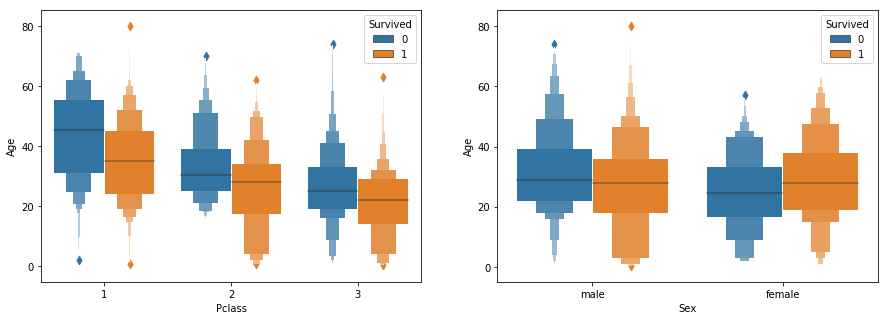

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.boxenplot(train_df['Pclass'], train_df['Age'], hue=train_df['Survived'])
plt.subplot(1, 2, 2)
sns.boxenplot(train_df['Sex'], train_df['Age'], hue=train_df['Survived'])

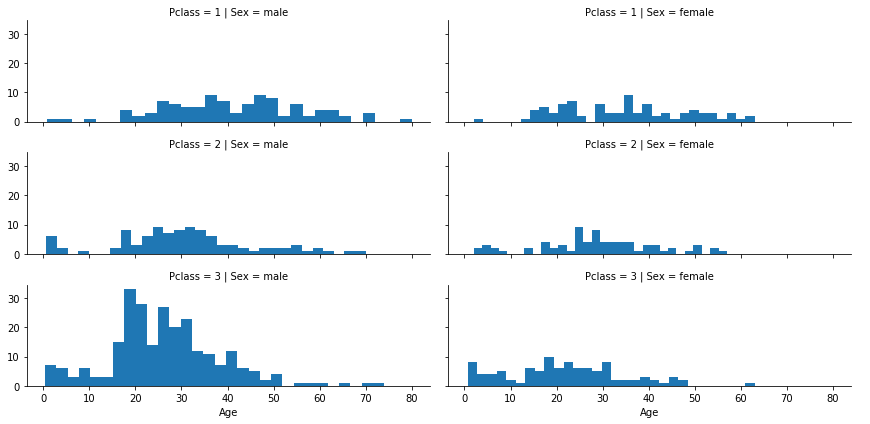

In [27]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.0, aspect=3.0)
grid.map(plt.hist, 'Age', bins=30)
grid.add_legend()

Using these plots, your friend argues that there are correlations between the `'Pclass'`, `'Sex'` and `'Age'` features within the dataset, and that `'Age'` shows influence in predicting a given passenger's survival. 

Aware of this new knowledge, you decide to create a function, `conditional_impute`, which performs imputation upon an `age` column within a Pandas `DataFrame` based upon both `Sex` and `Pclass` columns. Given that you are uncertain which statistic best models your data, you decide to once again to add a `choice` parameter which allows either the *mean* or *median* to be used for imputing the data.   

***Function arguments:***
 - `input_df` -> input `Pandas` DataFrame. 
 - `choice`-> Python `string` of either `'mean'` or `'median'`. Default is `'median'`. 

***Function Specifications:***
 - Name the function `conditional_impute`
 - Must take a Pandas `DataFrame` as input and return a `DataFrame` as output.
 - Should impute `Age` values based upon the descriptive statistic method specified by `choice`.
 - Round all imputed answers to 1 decimal point. 
 - If `choice` is not either `'mean'` or `'median'`,  a `ValueError` must be raised.  

In [0]:
def conditional_impute(input_dff, choice='median'):
  input_df = pd.DataFrame(input_dff)
  pd.options.mode.chained_assignment = None  # disable default='warn'
  
  data = pd.DataFrame(input_df)    
  if choice not in ['mean','median']:
    raise ValueError('choice is not mean or median')
  elif choice == 'mean':
    dfx = round(data.groupby(['Sex','Pclass'])[['Age']].mean(),1)
  elif choice == 'median':
    dfx = round(data.groupby(['Sex','Pclass'])[['Age']].median(),1)
   
  input_df.loc[input_df['Age'].isnull() == True, 'Age'] = 0

  for i in range(0,len(input_df)):
    if input_df.loc[i,'Sex'] == 'female':
      if input_df.loc[i,'Pclass'] == 1:
        y = dfx.Age[0]
        if input_df.loc[i,'Age'] == 0:
          input_df.Age[i] = y
      elif input_df.loc[i,'Pclass'] == 2:
        y = dfx.Age[1]
        if input_df.loc[i,'Age'] == 0:
          input_df.Age[i] = y
      elif input_df.loc[i,'Pclass'] == 3:
        y = dfx.Age[2]
        if input_df.loc[i,'Age'] == 0:
          input_df.Age[i] = y
    elif input_df.loc[i,'Sex'] == 'male':
      if input_df.loc[i,'Pclass'] == 1:
        y = dfx.Age[3]
        if input_df.loc[i,'Age'] == 0:
          input_df.Age[i] = y
      elif input_df.loc[i,'Pclass'] == 2:
        y = dfx.Age[4]
        if input_df.loc[i,'Age'] == 0:
          input_df.Age[i] = y
      elif input_df.loc[i,'Pclass'] == 3:
        y = dfx.Age[5]
        if input_df.loc[i,'Age'] == 0:
          input_df.Age[i] = y
          

  return input_df

In [29]:
conditional_impute(train_df, choice='mean')[['Name','Age']].tail()

,Name,Age
886,"Montvila, Rev. Juozas",27.0
887,"Graham, Miss. Margaret Edith",19.0
888,"Johnston, Miss. Catherine Helen ""Carrie""",21.8
889,"Behr, Mr. Karl Howell",26.0
890,"Dooley, Mr. Patrick",32.0


_**Expected Outputs:**_
```python
conditional_impute(train_df, choice='median')[['Name','Age']].tail()

```

><table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Name</th>      <th>Age</th>    </tr>  </thead>  <tbody>    <tr>      <th>886</th>      <td>Montvila, Rev. Juozas</td>      <td>27.0</td>    </tr>    <tr>      <th>887</th>      <td>Graham, Miss. Margaret Edith</td>      <td>19.0</td>    </tr>    <tr>      <th>888</th>      <td>Johnston, Miss. Catherine Helen "Carrie"</td>      <td>21.5</td>    </tr>    <tr>      <th>889</th>      <td>Behr, Mr. Karl Howell</td>      <td>26.0</td>    </tr>    <tr>      <th>890</th>      <td>Dooley, Mr. Patrick</td>      <td>32.0</td>    </tr>  </tbody></table>

<br><br>

```python
conditional_impute(train_df, choice='mean')[['Name','Age']].tail()
```

> <table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Name</th>      <th>Age</th>    </tr>  </thead>  <tbody>    <tr>      <th>886</th>      <td>Montvila, Rev. Juozas</td>      <td>27.0</td>    </tr>    <tr>      <th>887</th>      <td>Graham, Miss. Margaret Edith</td>      <td>19.0</td>    </tr>    <tr>      <th>888</th>      <td>Johnston, Miss. Catherine Helen "Carrie"</td>      <td>21.8</td>    </tr>    <tr>      <th>889</th>      <td>Behr, Mr. Karl Howell</td>      <td>26.0</td>    </tr>    <tr>      <th>890</th>      <td>Dooley, Mr. Patrick</td>      <td>32.0</td>    </tr>  </tbody></table>

## Question 2: Feature Engineering 

Having considered missing data, we can now further prepare our dataset for use within a model by performing feature engineering.

### Question 2.1: What's in a name?

When you originally received the titanic dataset, you were excited to see the `Name` feature included, as you believed this might be another source of information to help infer a person's social status on the ship. To use this feature however, we need to extract an individual's _title_ from his/her name, as calling `train_df['Name'].unique().shape` tells us that every `Name` entry within our train dataset is currently unique. 

Go ahead and perform this transformation by writing a function called `extract_title`, which adds an extra `Title` column to our dataframe into which is placed a person's given title found within the `Name` column. 

Examples of title extraction; 
 - `Braund, Mr. Owen Harris` maps to a title of `Mr.`
 - `Heikkinen, Miss. Laina` maps to a title of `Miss.`

***Function arguments:***
 - `input_df` -> input `Pandas` DataFrame.

***Function specifications:***
 - Name the function `extract_title`
 - Must take any Pandas `DataFrame` as input and return a `DataFrame` as output with an additional `Title` column.
 - Assume that `input_df` represents a DataFrame possessing a `'Name'` column, with each corresponding row entry being a `string`-based name containing exactly one title. 
 - Assume that a title is represented by a word with two or more characters ending in a `.`

In [0]:
def extract_title(input_df):
  my_df = pd.DataFrame(input_df)
  x = input_df.Name.values
  titles = []
  
  for i in range(0, len(x)):
    inner_list = x[i].split(" ")
    for j in range(0, len(inner_list)-1):
      if inner_list[j][-1] == '.'and len(inner_list[j]) > 2:
        titles.append(inner_list[j])
          
  if len(titles) == len(input_df): 
    my_df['Title'] = titles
    
  return my_df

In [31]:
extract_title(train_df)['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.'], dtype=object)

_**Expected Outputs:**_
```python

extract_title(train_df)['Title'].unique() == ['Mr.', 'Mrs.', 'Miss.', 'Master.',
                                              'Don.', 'Rev.', 'Dr.', 'Mme.','Ms.',
                                              'Major.', 'Lady.', 'Sir.', 'Mlle.',
                                              'Col.', 'Capt.','Countess.', 'Jonkheer.']


extract_title(test_df)['Title'].unique() == ['Mr.', 'Mrs.', 'Miss.', 'Master.', 
                                             'Ms.', 'Col.', 'Rev.', 'Dr.','Dona.']

``` 

### Question 2.2: Feature Selection

Having your `'Title'` column prepared, you perform a quick examination to see the distribution of its categories with relation to the gender of a passenger.

(***Note:*** Even if you weren't able to solve Q2.1, *we have imported the correct dataframe*, `title_df` in the code section beneath for your continued use.)

In [32]:
# Load the correct form of the train.csv for Q 2.2
title_df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/titanic_train_title.csv')
pd.crosstab(index=title_df['Title'], columns=title_df['Sex'])

Sex,female,male
Title,,
Capt.,0,1
Col.,0,2
Countess.,1,0
Don.,0,1
Dr.,1,6
Jonkheer.,0,1
Lady.,1,0
Major.,0,2
Master.,0,40


From this observation, you realise that a just small group of categories represent a considerable majority of datapoints within the column. Using this outcome in your favour, you decide to only preserve the titles of `['Mr.' , 'Mrs.' , 'Master.', 'Miss.']` and to group the remaining items into a single category called `'Uncommon'`. 


To accomplish your objective, write a function called `group_titles` which takes in your dataframe containing the `Title` column, along with a selection of `preserved_titles`, and returns the dataframe with the modified `Title` column in which the updated groupings are reflected.

***Function arguments:***
 - `input_df` -> input `Pandas` DataFrame.
 - `preserved_titles` -> A 1-D `list` of Python `strings` representing the categories of titles to be preserved. The remaining categories are grouped together as the new `'Uncommon'` category. 

***Function specifications:***
 - Name the function `group_titles`
 - Must take any Pandas `DataFrame` as input and return a `DataFrame` with the `Title` column containing newly regrouped categories.
 - Assume that `input_df` represents a DataFrame possessing a `'Title'` column, with each corresponding row entry being a `string`-based title. 

In [0]:
def group_titles(input_dff, preserved_titles):
    input_df = pd.DataFrame(input_dff)
    x = input_df.Title.values
    new_title = []
    for i in x:
      if i not in preserved_titles:
        new_title.append('Uncommon')
      else:
        new_title.append(i)
        
    input_df['Title'] = new_title
    
    return input_df

In [34]:
group_titles(title_df, preserved_titles=['Miss.', 'Master.'])['Title'].unique()

array(['Uncommon', 'Miss.', 'Master.'], dtype=object)

_**Expected Outputs:**_
```python
group_titles(title_df, preserved_titles=['Mr.', 'Mrs.', 'Miss.', 'Master.'])['Title'].unique() == 
['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Uncommon']

group_titles(title_df, preserved_titles=['Miss.', 'Master.'])['Title'].unique() == 
['Uncommon', 'Miss.', 'Master.']
```

### Question 2.3: Feature Encoding

Finally, you further decide that it's time to encode your new categorical features within the `'Title'` column using [dummy variables.](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) 

Write a function called `encode_titles` which encodes the various categories contained within the `Title` column of an input DataFrame as numerically-based dummy variables. 

***Function arguments:***
 - `input_df` -> input `Pandas` DataFrame.

***Function specifications:***
 - Name the function `encode_titles`
 - Must take any Pandas `DataFrame` as input and return a `DataFrame` as output with an expanded set of columns representing dummy variables corresponding to the newly regrouped `Title` categories.
 - Assume that `input_df` represents a DataFrame possessing a `'Title'` column, with each corresponding row entry being a `string`-based title. 
 - **NB!** Ensure that your dummy encoding avoids the [dummy variable trap](https://stattrek.com/multiple-regression/dummy-variables.aspx). As a ***hint***, look at the documentation for the Pandas [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function.

(***Note:*** Even if you weren't able to solve Q2.2, *we have imported the correct dataframe*, `title_regrouped_df` in the code section beneath for your continued use.)

In [0]:
# Load the correct form of the train.csv for Q 2.2
title_regrouped_df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/titanic_train_title_regrouped.csv')

Function implementation:

In [0]:
def encode_titles(input_dff):
    input_df = pd.DataFrame(input_dff)
    input_df = pd.get_dummies(input_df, columns=["Title"], drop_first=True)
    
    return input_df

In [37]:
encode_df = encode_titles(title_regrouped_df)
dummy_cols = [col for col in encode_df if col.startswith('Title')]
encode_df[dummy_cols].head()

,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Uncommon
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0


_**Expected Outputs:**_
```python
encode_df = encode_titles(title_regrouped_df)
dummy_cols = [col for col in encode_df if col.startswith('Title')]
encode_df[dummy_cols].head()
```

><table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Title_Miss.</th>      <th>Title_Mr.</th>      <th>Title_Mrs.</th>      <th>Title_Uncommon</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>0</td>      <td>1</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>1</th>      <td>0</td>      <td>0</td>      <td>1</td>      <td>0</td>    </tr>    <tr>      <th>2</th>      <td>1</td>      <td>0</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>3</th>      <td>0</td>      <td>0</td>      <td>1</td>      <td>0</td>    </tr>    <tr>      <th>4</th>      <td>0</td>      <td>1</td>      <td>0</td>      <td>0</td>    </tr>  </tbody></table>